['', 'trial', 'val_basic', 'delay', 'val_prc', 'response', 'RT', 'respSide', 'sideNOW', 'Version', 'loopID', 'Context']


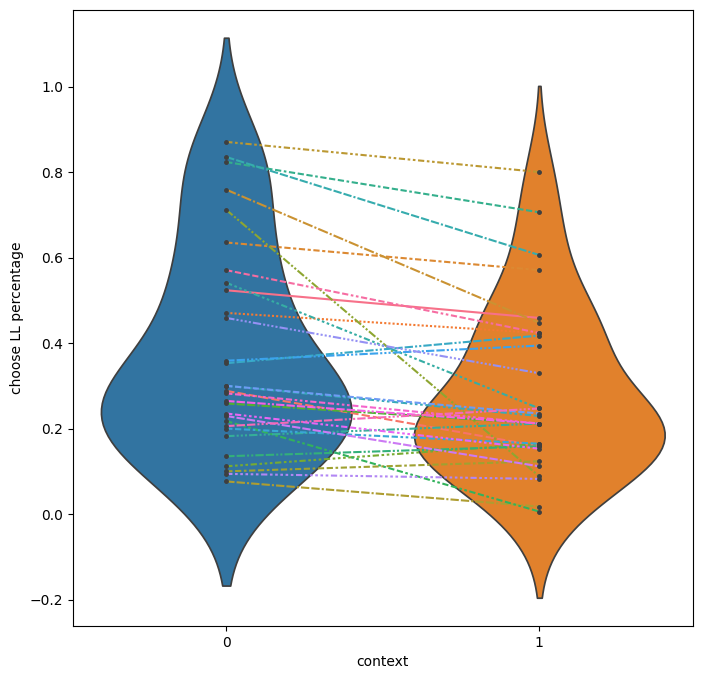

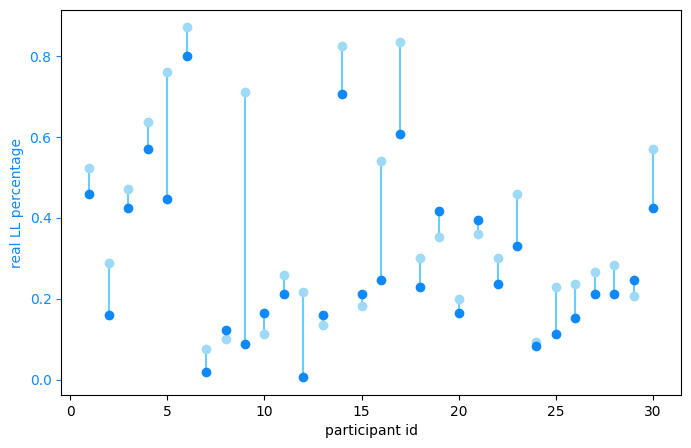

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 13 2024

@author: Yaning
Data from Ben
Data file name: intertemporal_choice_dataset_all_trials.csv
"""

# get the real percentage of the participants
%run Documents/pyro_models/files_to_run/percentage_comparison.ipynb

import math
import os
# from turtle import position
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform, Bernoulli, Categorical, Gamma
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
# import pandas as pd
import numpy as np
import scipy.stats as stats 

In [10]:
# load inferred parameters
summary_dict = torch.load("Documents/pyro_models/files_to_run/results/beta_summary_0.pth")

In [11]:
summary_dict.keys()

dict_keys(['beta', 'group_beta_mean', 'group_beta_sigma', 'group_log_sigma_es_mean', 'group_log_sigma_es_sigma', 'group_log_sigma_u_mean', 'group_log_sigma_u_sigma', 'group_mean_u_mean', 'group_mean_u_sigma', 'log_sigma_es', 'log_sigma_u', 'mean_u'])

In [12]:
# transfer the inferred parameters to cpu
pos_mean_u = np.array((summary_dict["mean_u"]["mean"]).to("cpu"))
pos_sigma_u = np.array(np.exp((summary_dict["log_sigma_u"]["mean"]).to("cpu")))
pos_sigma_es = np.array(np.exp((summary_dict["log_sigma_es"]["mean"]).to("cpu")))
pos_beta = np.array((summary_dict["beta"]["mean"]).to("cpu"))

In [17]:
# inferred_param = np.array((summary_dict["log_sigma_u"]["std"]).to("cpu"))
test = pos_mean_u.reshape(2,30)

In [18]:
pos_beta

array([0.38190271, 0.38961865, 0.24255693, 0.35315719, 0.21827797,
       0.11603746, 0.35158355, 0.22792181, 0.09598137, 0.33638073,
       0.27303348, 0.11547081, 0.2566533 , 0.2949456 , 0.32964228,
       0.11951249, 0.71043087, 0.1577497 , 0.36801792, 0.36081466,
       0.37069972, 0.29873551, 0.2949983 , 0.25041321, 0.12219627,
       0.39703162, 0.19816162, 0.28754265, 0.16082181, 0.02749708,
       0.25576216, 0.53987351, 0.27261572, 0.27745938, 0.21551464,
       0.28170291, 0.61032836, 0.15659915, 0.13003829, 0.50754248,
       0.21195099, 0.22407252, 0.85247857, 0.44021743, 0.59193644,
       0.07395349, 0.52082976, 0.23161757, 0.28560251, 0.22824788,
       0.29687214, 0.19063401, 0.13617058, 0.18729596, 0.1450293 ,
       0.2930647 , 0.25940113, 0.22042953, 0.11175909, 0.0485475 ])

In [19]:
np.mean(test, axis=-1)

array([-7.09168404, -7.11049837])

In [7]:
# shape the real data without separating the context
# because the inferred parameters do not separate those two
real_data = data.reshape(60,170,8)

In [44]:
# replicate the inferred parameters to 170 (trial amount)
# mean_u = np.tile(pos_mean_u[:, np.newaxis], (1, 170))
# sigma_u = np.tile(pos_sigma_u[:, np.newaxis], (1, 170))
sigma_es = np.tile(pos_sigma_es[:, np.newaxis], (1, 170))
beta = np.tile(pos_beta[:, np.newaxis], (1, 170))

In [45]:
# use real data condition and the inferred parameters to get estimation values
# inferred_estimation = (mean_u*real_data[:,:,2]*sigma_es**2 + 
#  real_data[:,:,3]*sigma_u**2)/(real_data[:,:,2]*sigma_es**2 + sigma_u**2)

sigma_u = torch.tensor(6.)
inferred_estimation = (torch.tensor(0.5)*real_data[:,:,2]*sigma_es**2 + 
 real_data[:,:,3]*sigma_u**2)/(real_data[:,:,2]*sigma_es**2 + sigma_u**2)

# change everything to tensor
real_data = torch.tensor(real_data)
inferred_estimation = torch.tensor(inferred_estimation)
beta = torch.tensor(beta)

# create softmax and the bernoulli distribution
softmax_args = torch.stack([beta*inferred_estimation, beta*real_data[:,:,1]])
p = torch.softmax(softmax_args, dim = 0)[0]
inferred_response_distr = Bernoulli(probs=p)

/tmp/ipykernel_1081112/4033987372.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  real_data = torch.tensor(real_data)
/tmp/ipykernel_1081112/4033987372.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inferred_estimation = torch.tensor(inferred_estimation)


In [46]:
# get one possible predict actions
inferred_response = inferred_response_distr.sample()

In [47]:
# reshape to with contexts for plotting
reshaped_inferred_response = inferred_response.reshape(2,30,170)

Check the graph fitting.

In [48]:
# calculate the predicted LL choosing percentage
inferred_percentages = []
for i in reshaped_inferred_response:
    temp = []
    for j in i:
        temp.append(len(list(filter(lambda x: (x == 1), j))
                ) / len(j))
    inferred_percentages.append(temp)

In [49]:
inferred_percentages = np.array(inferred_percentages)

In [50]:
# separate to pairs so can make line plot
infer_line = []
for i,j in zip(inferred_percentages[0], inferred_percentages[1]):
    infer_line.append([i,j])

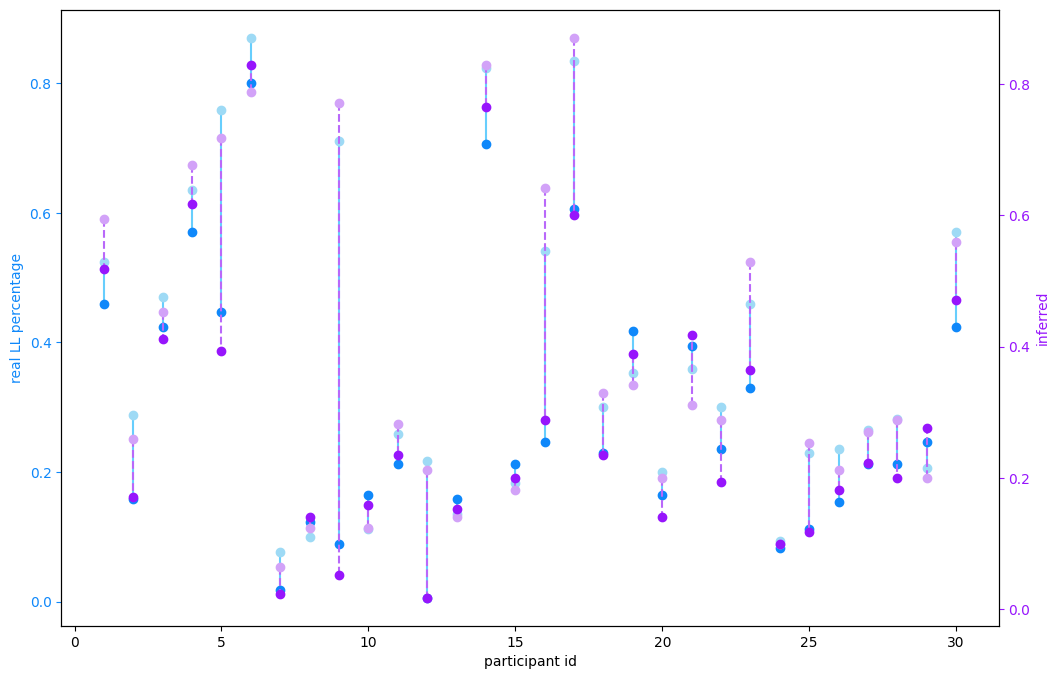

In [51]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(infer_line)):
    x = [i+1, i+1]
    y_inferred = [infer_line[i][0], infer_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

Check the correctly predicted percentage.

In [52]:
# create only one dimension array
# get how many are correctly predicted
real_response = real_data[:,:,4].view(-1)
num = 0
for i in range(len(real_response)):
    if inferred_response.view(-1)[i] == real_response[i]:
        num = num + 1

In [54]:
num/len(real_response)

0.8539215686274509

Plot the parameters with the real LL choosing percentage.

In [55]:
# plot_pos_param = pos_sigma_es.reshape(2,30) - pos_sigma_u.reshape(2,30)
plot_param = pos_sigma_es.reshape(2,30)

In [24]:
np.corrcoef(pos_sigma_u, pos_sigma_es)

array([[ 1.        , -0.85603542],
       [-0.85603542,  1.        ]])

In [56]:
# separate to pairs so can make line plot
param_line = []
for i,j in zip(plot_param[0], plot_param[1]):
    param_line.append([i,j])

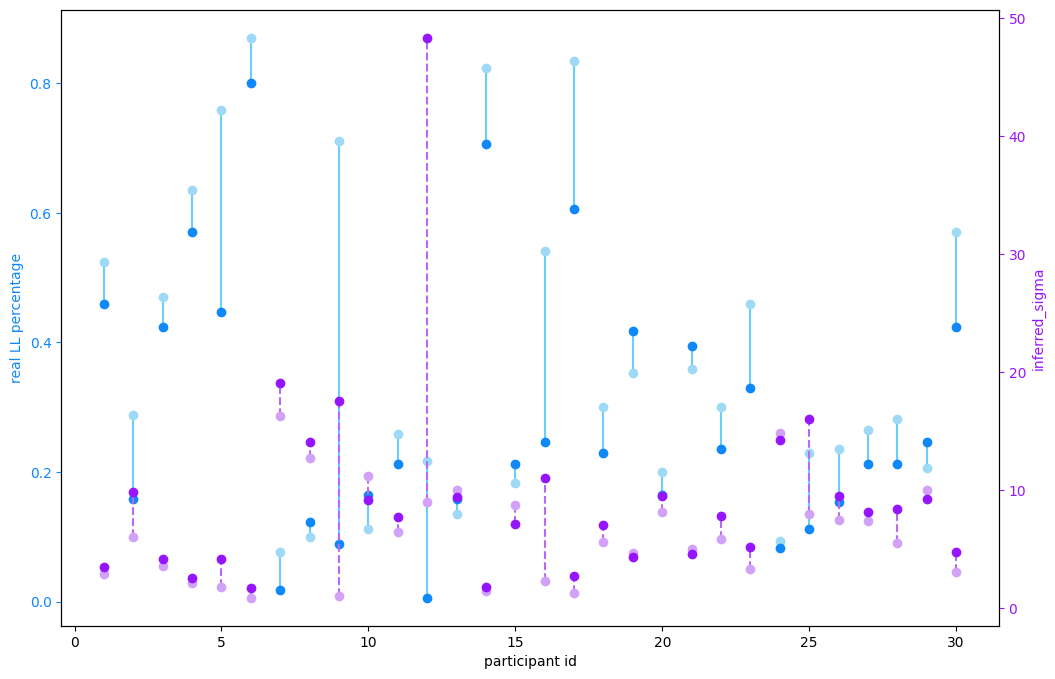

In [57]:
# plot real percentage and infered parameters together
fig, ax = plt.subplots(figsize=(15,8))

# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]

# Make some space on the right side for the extra y-axis.
fig.subplots_adjust(right=0.75)

# lighter dots are cafe and darker dots are gamble
# plot the real percentage (blue)
for i in range(len(line_data)):
    x = [i+1, i+1]
    y = [line_data[i][0], line_data[i][1]]
    axes[0].plot(x, y, color="#67cefd", ls = '-')
    axes[0].plot(i+1, y[0], color ="#9edaf5", marker = "o")
    axes[0].plot(i+1, y[1], color = "#0f88fa", marker = "o")
axes[0].set_ylabel("real LL percentage", color = "#0f88fa")
axes[0].tick_params(axis='y', colors = "#0f88fa")
axes[0].set_xlabel("participant id")

# inferred percentages (purple)
for i in range(len(param_line)):
    x = [i+1, i+1]
    y_inferred = [param_line[i][0], param_line[i][1]]
    axes[1].plot(x, y_inferred, color="#b968fa", ls = "--")
    axes[1].plot(i+1, y_inferred[0], color = "#d2a2f8", marker = "o")
    axes[1].plot(i+1, y_inferred[1], color = "#9715fc", marker = "o")
axes[1].set_ylabel("inferred_sigma", color = "#9715fc")
axes[1].tick_params(axis='y', colors = "#9715fc")



plt.show()

In [8]:
import torch
import pyro
import pyro.distributions as dist

# Define some example data
data = torch.tensor([[1.0, 2.0], [3.0, 4.0]])

# Use plate context with to_event()
with pyro.plate("data", data.shape[0]):
    # Specify that the last dimension of the tensor is an event dimension
    x = pyro.sample("x", dist.Normal(0, 1).expand([data.shape[0]]).to_event(1))

print(x)

tensor([[-0.7453,  0.3778],
        [-1.1641, -0.1229]])


In [9]:
n_dist = dist.Normal(0,1)

In [27]:
n_dist.expand([data.shape[0]]).to_event(1)

Independent(Normal(loc: torch.Size([2]), scale: torch.Size([2])), 1)

In [16]:
data.shape[0].to_event(1)

AttributeError: 'int' object has no attribute 'to_event'

In [33]:
pyro.deterministic('sig', 1/torch.sqrt(torch.tensor(4.)))

tensor(0.5000)